In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

# WITHOUT FEATURES

In [2]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq)

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

100%|██████████| 50/50 [00:02<00:00, 19.87it/s, epoch=8/8, avg_epoch_loss=0.851]


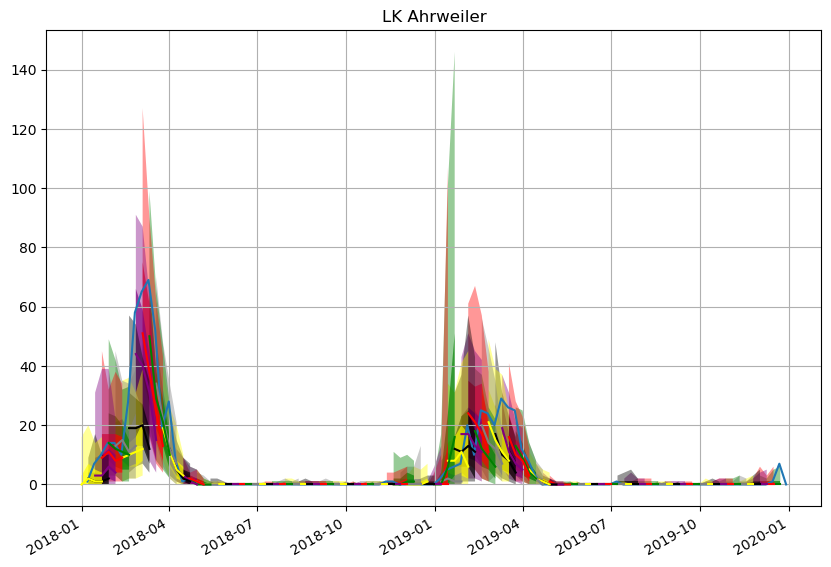

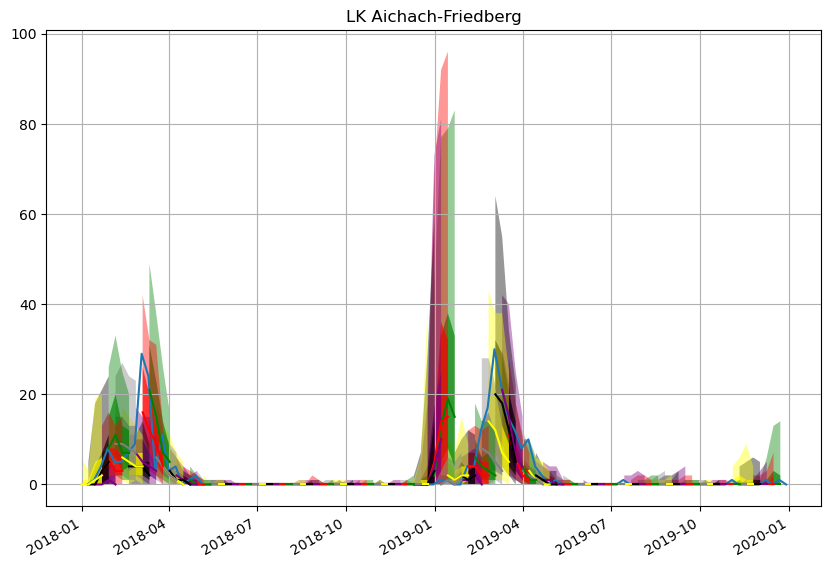

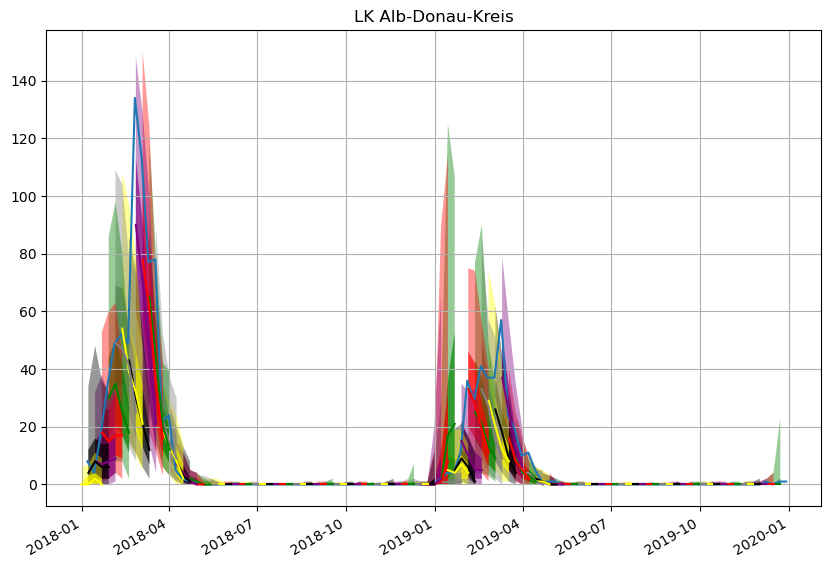

In [4]:
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:3]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

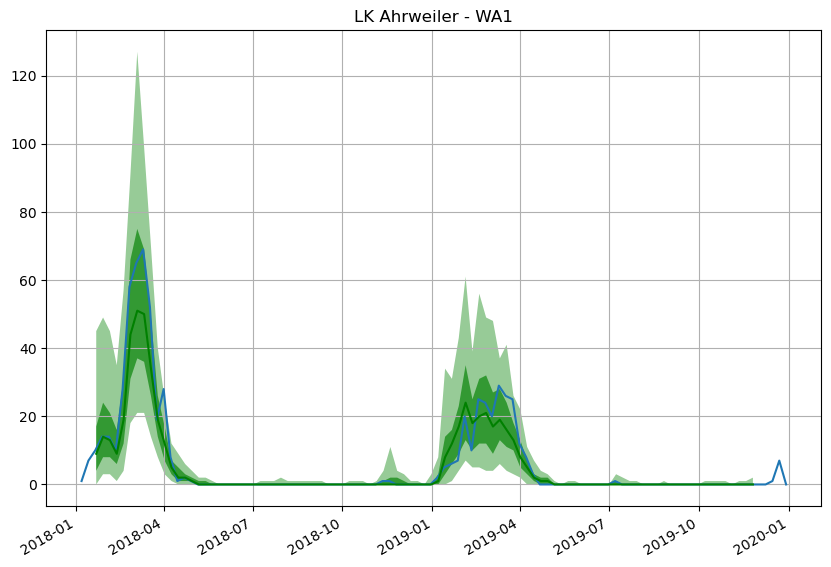

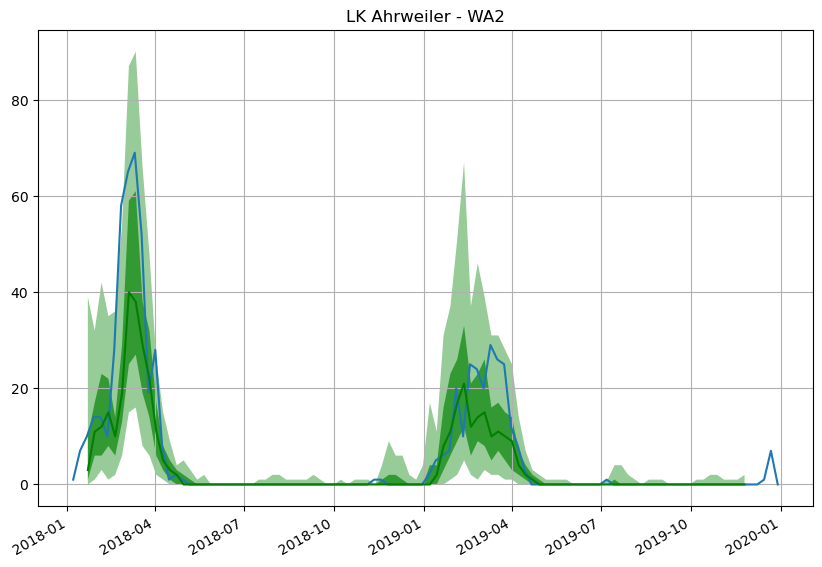

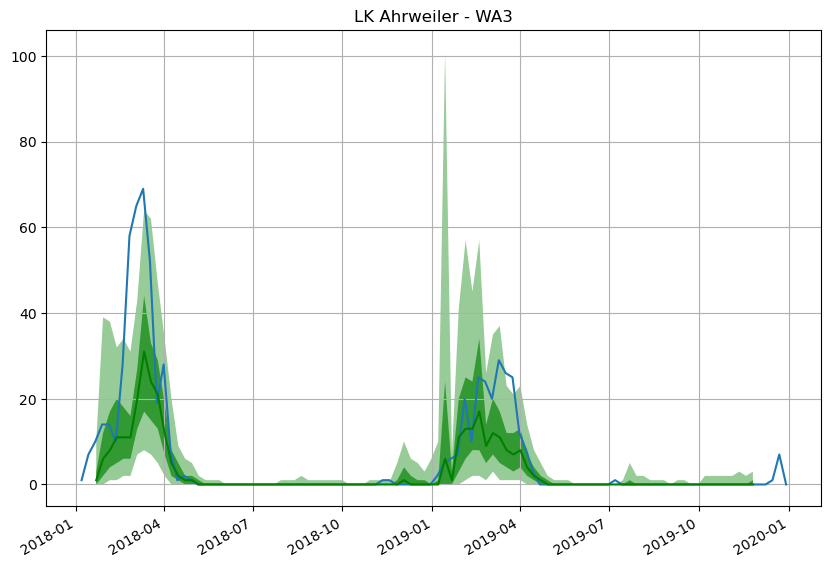

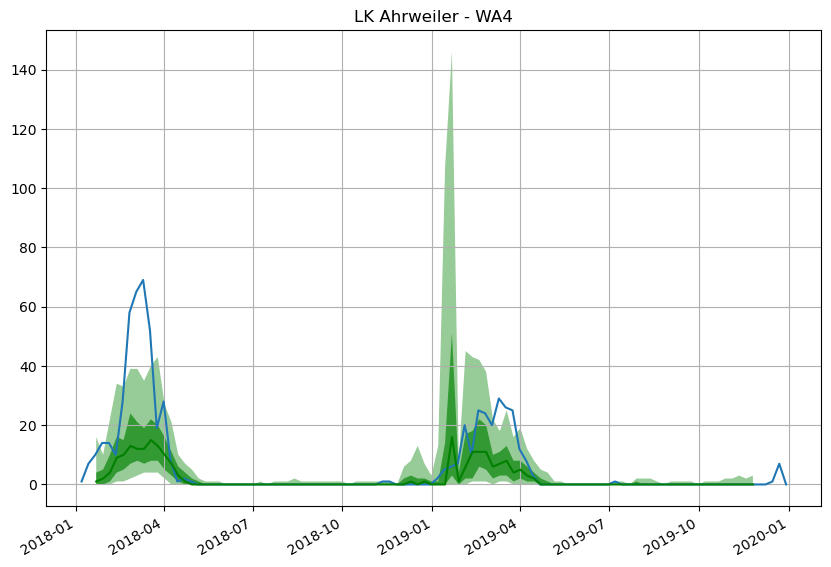

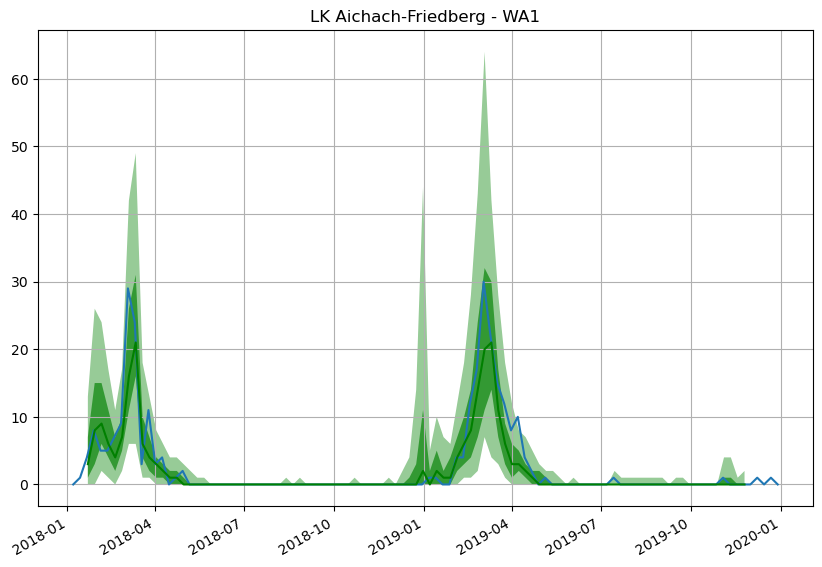

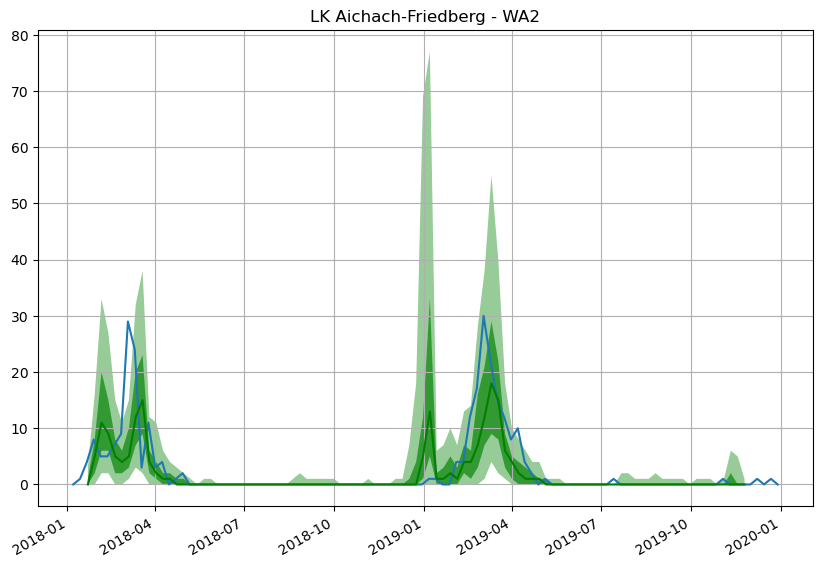

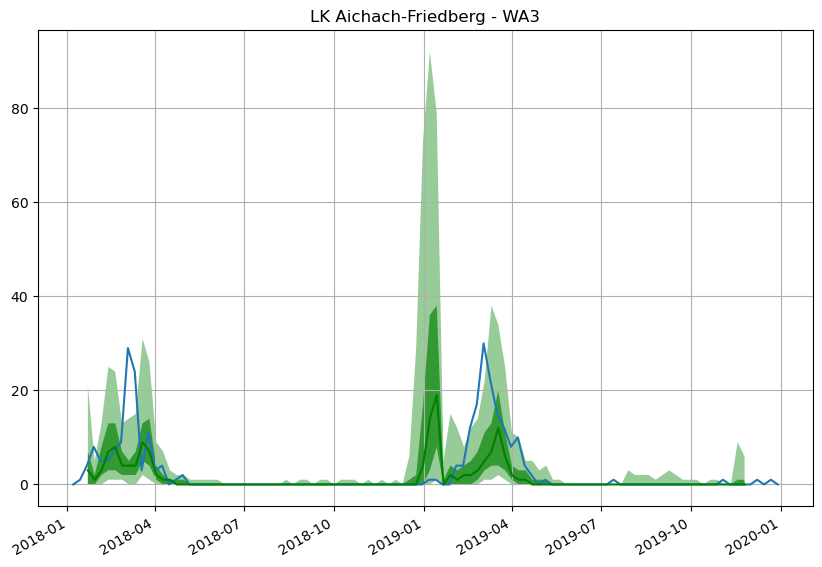

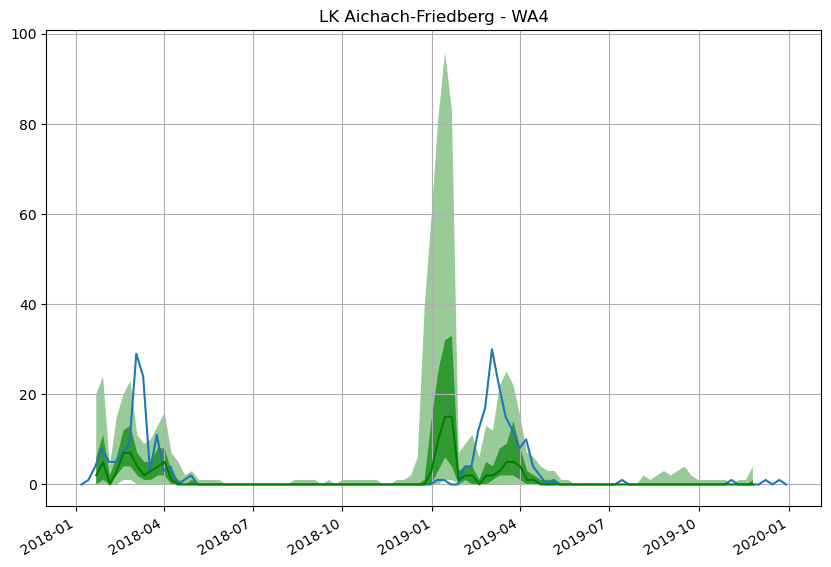

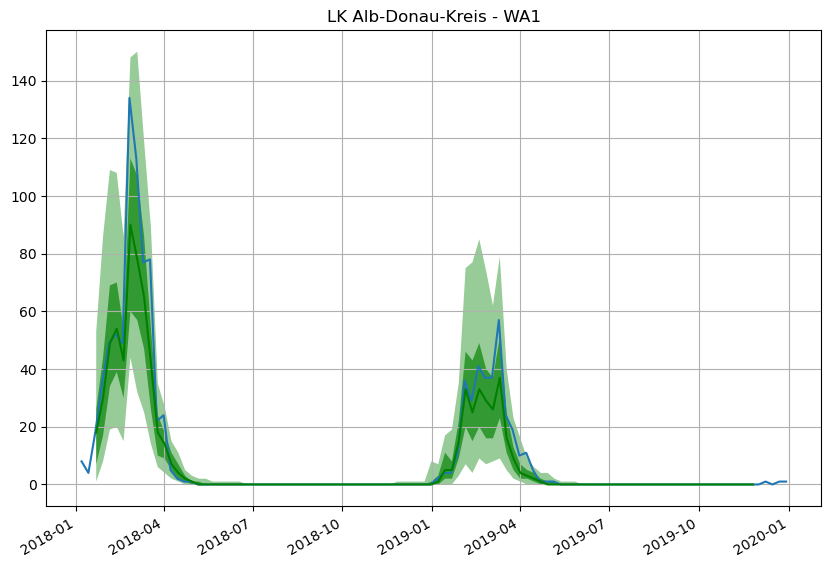

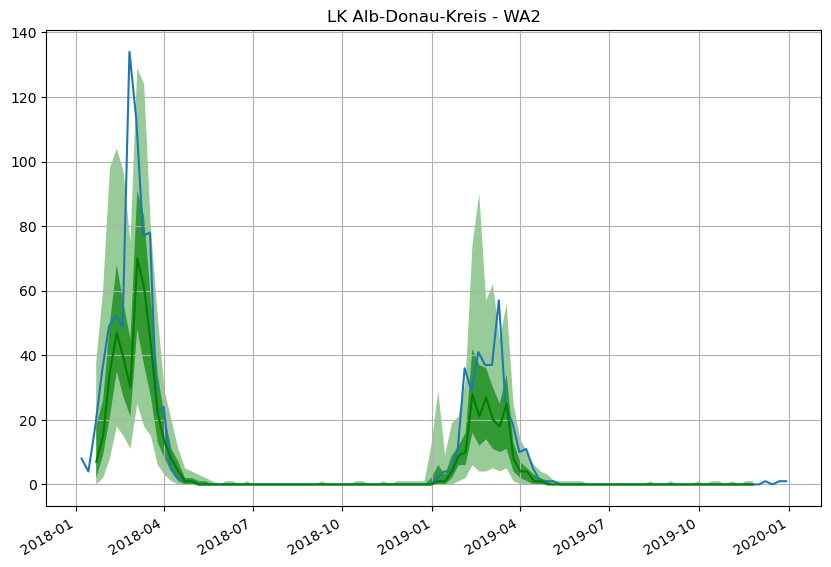

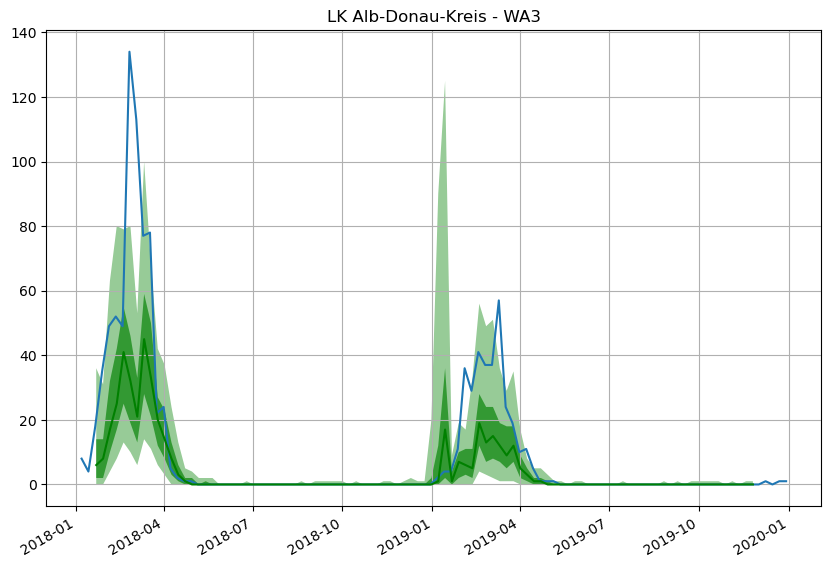

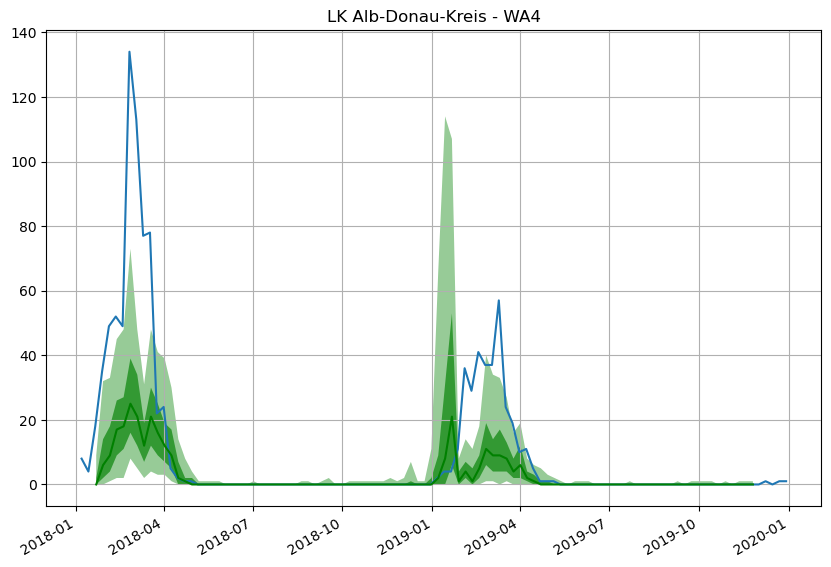

In [5]:
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
print_forecasts_by_week(config, one_ts_df, forecast_dict, locations[:3], [1,2,3,4], plot_begin_at_trainstart=False)

In [ ]:
models_dict = {"DeepAR":config.deeparestimator}#, "FFNN":config.feedforwardestimator}
evaluator_df_dict = {}
for key in models_dict.keys():
    forecasts, tss = model(config, train_set, test_set, models_dict[key])

    # saving the true values
    split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]
    # saving the 1 to 4 week ahead forecasts
    forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
    # Evaluation
    evaluator = Evaluator(quantiles=config.quantiles)
    evaluator_df = pd.DataFrame()
               
    # iterate over the 4 different week-aheads
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        for location in locations[:]:
            item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
            evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
        agg_metrics["item_id"] = f"aggregated {d}"
        evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
    evaluator_df_dict[key] = evaluator_df
plot_coverage(config, evaluator_df_dict)
#print(evaluator_df_dict)

In [ ]:
print_forecasts_by_week(config, one_ts_df, forecast_dict, locations, [1,2,3,4], plot_begin_at_trainstart=False)

# WITH FEATURES

In [6]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    one_ts_df.loc[one_ts_df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0]

In [7]:
print(one_ts_df.loc[one_ts_df["LK Ahrweiler"] == 1].location.unique())
print(neighbourhood_df.loc[neighbourhood_df["LK Ahrweiler"]>0,'LK Ahrweiler'])

['LK Euskirchen' 'LK Mayen-Koblenz' 'LK Neuwied' 'LK Rhein-Sieg-Kreis'
 'LK Vulkaneifel' 'SK Bonn']
LK Euskirchen          1
LK Mayen-Koblenz       1
LK Neuwied             1
LK Rhein-Sieg-Kreis    1
LK Vulkaneifel         1
SK Bonn                1
Name: LK Ahrweiler, dtype: int64


In [8]:
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]

start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq,
                                              feat_static_real=["population"]+locations, feat_dynamic_real=["week"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq,
                                             feat_static_real=["population"]+locations, feat_dynamic_real=["week"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

In [10]:
'''
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:10]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()'''

'\n#train and evaluate the model\nforecasts, tss = model(config, train_set, test_set, config.deeparestimator)\nwindows_per_location = int(len(test_set) / len(locations))\nfor location in locations[:10]:\n    #plot the forecasts\n    fig, ax = plt.subplots(1, 1, figsize=(10, 7))\n    plt.title(f\'{location}\')\n    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)\n    plt.plot((one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                            (one_ts_df.index <= config.test_end_time) &\n                            (one_ts_df.index >= config.train_end_time)].index),\n             one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                           (one_ts_df.index <= config.test_end_time) &\n                           (one_ts_df.index >= config.train_end_time), \'value\'])\n    plt.grid(which="both")\n    #define the colors to use for each different window\n    color = [\'g\', \'r\', \'purple\', \'black\', \'yellow\', \'grey\']

100%|██████████| 50/50 [00:26<00:00,  1.86it/s, epoch=8/8, avg_epoch_loss=0.822]
Running evaluation: 411it [00:01, 271.65it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 262.54it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 271.81it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 269.87it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

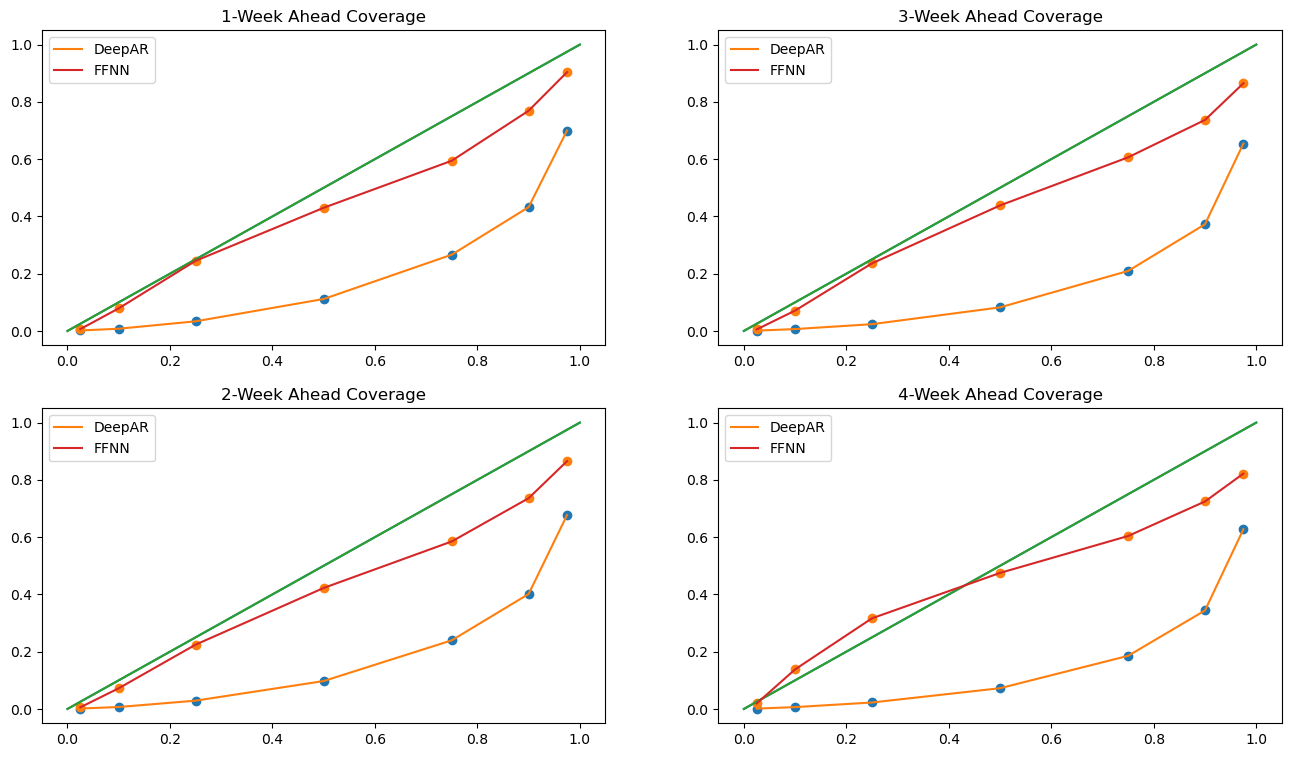

In [9]:
models_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
evaluator_df_dict = {}
forecasts_dict = {}
for key in models_dict.keys():
    forecasts, tss = model(config, train_set, test_set, models_dict[key])

    # Splitting the forecasts into their weekly contribution
    split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]
    forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
    # Evaluation with the quantiles of the configuration
    evaluator = Evaluator(quantiles=config.quantiles)
    evaluator_df = pd.DataFrame()
               
    # iterate over the 4 different week-aheads
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        for location in locations[:]:
            item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
            evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
        agg_metrics["item_id"] = f"aggregated {d}"
        evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
    evaluator_df_dict[key] = evaluator_df
    forecasts_dict[key] = forecast_dict
plot_coverage(config, evaluator_df_dict)

DeepAR


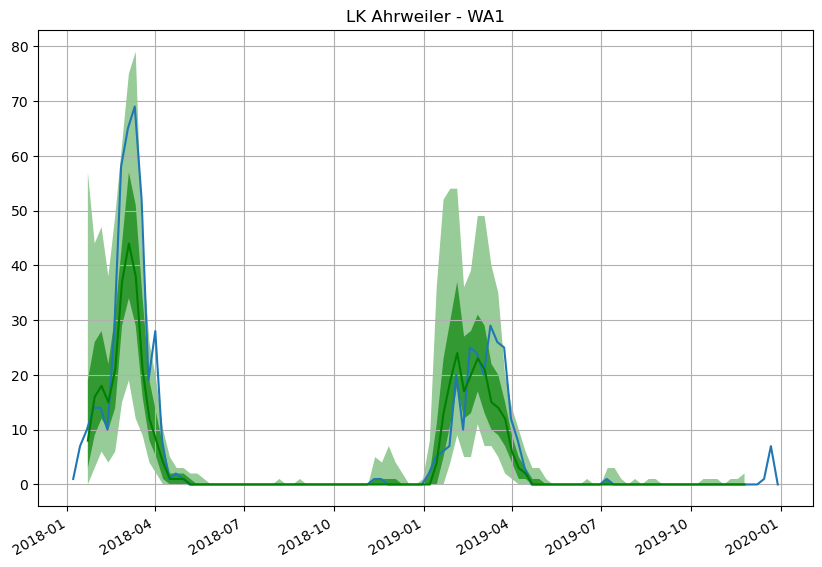

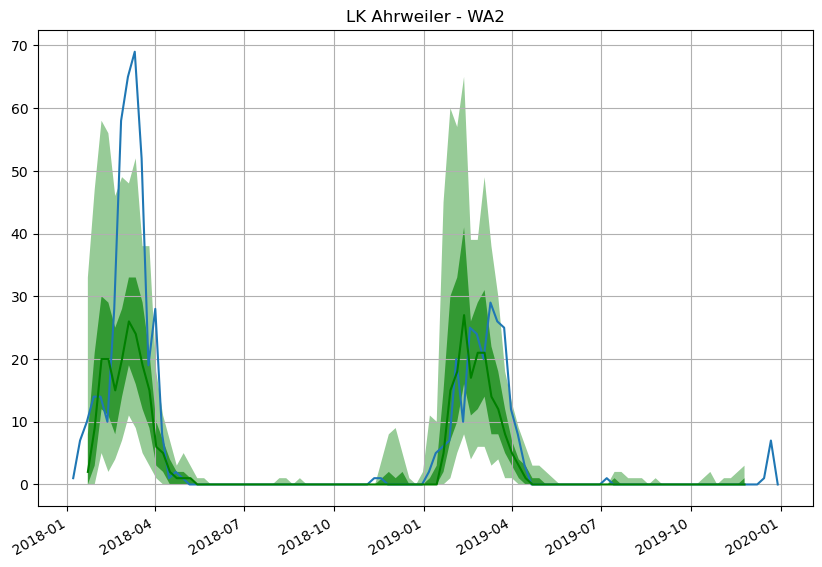

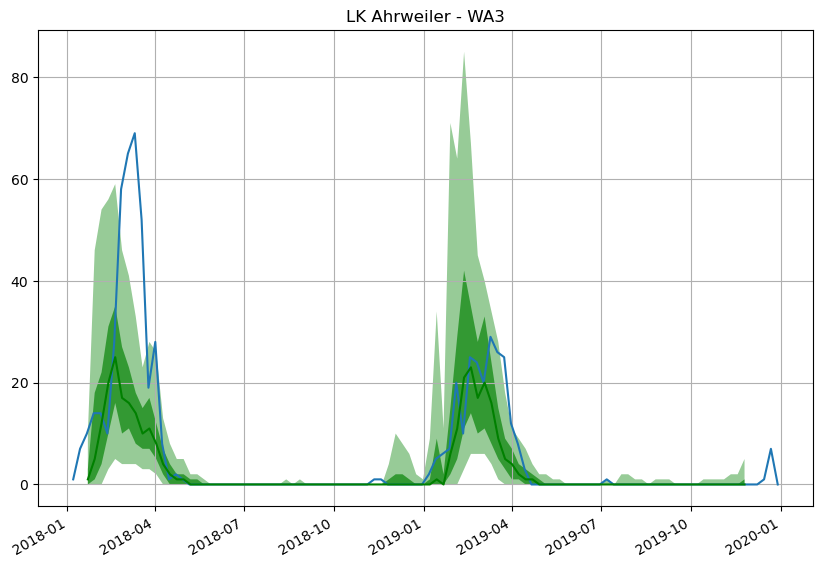

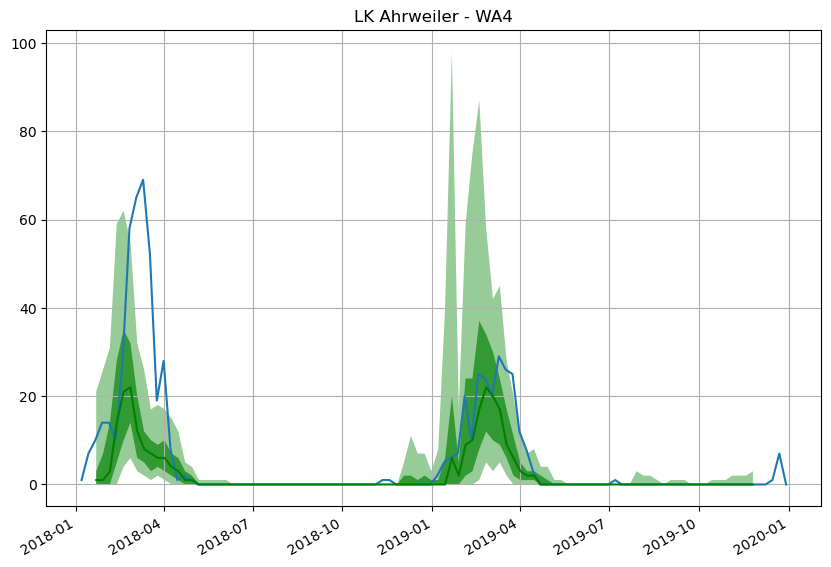

            item_id  Coverage[0.1]  Coverage[0.25]  Coverage[0.5]  \
0  LK Ahrweiler {1}       0.010309        0.030928       0.092784   
0  LK Ahrweiler {2}       0.000000        0.020619       0.082474   
0  LK Ahrweiler {3}       0.000000        0.010309       0.061856   
0  LK Ahrweiler {4}       0.000000        0.020619       0.051546   

   Coverage[0.75]  Coverage[0.9]  
0        0.268041       0.402062  
0        0.278351       0.412371  
0        0.257732       0.422680  
0        0.185567       0.422680  
FFNN


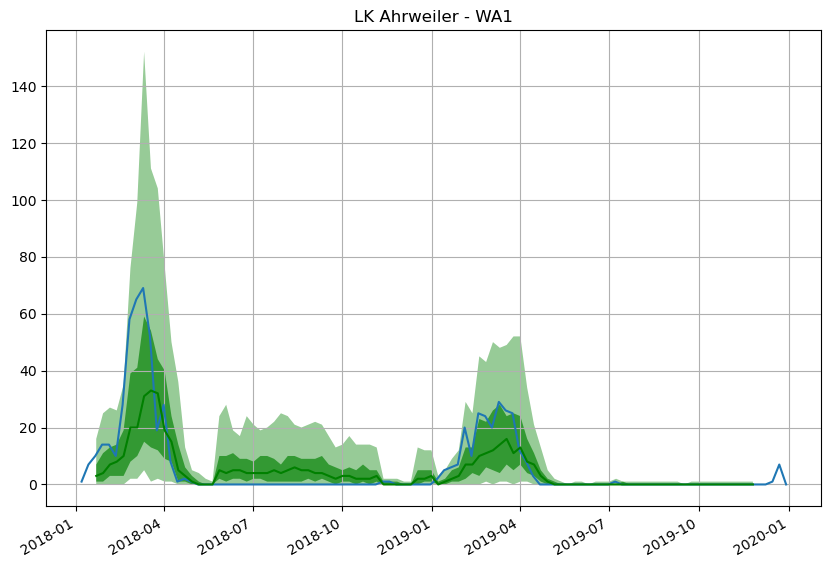

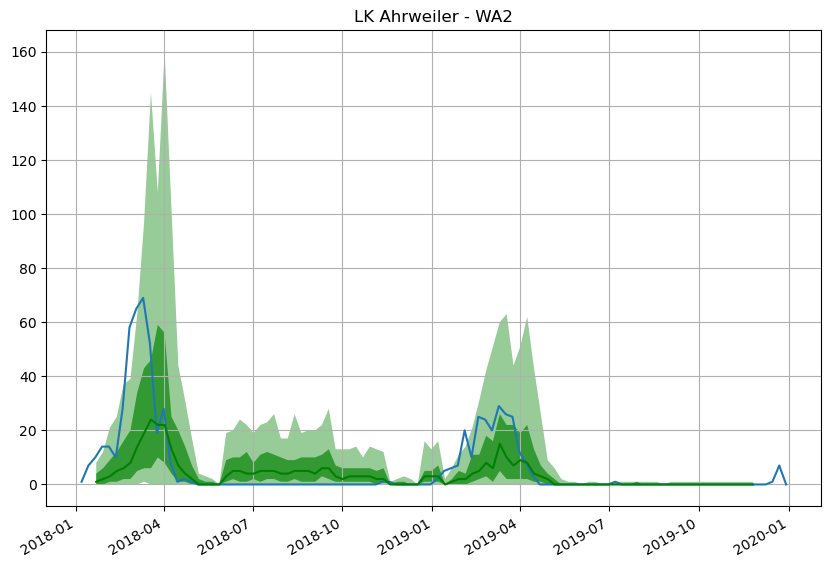

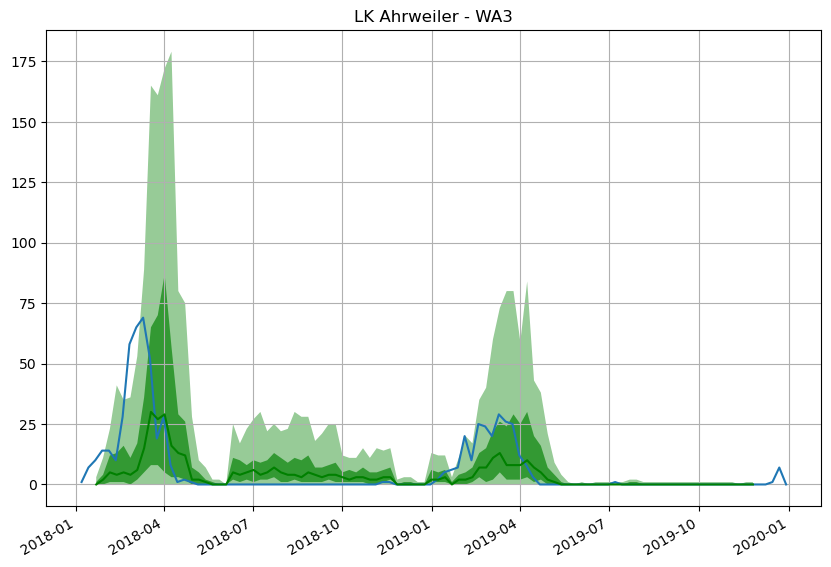

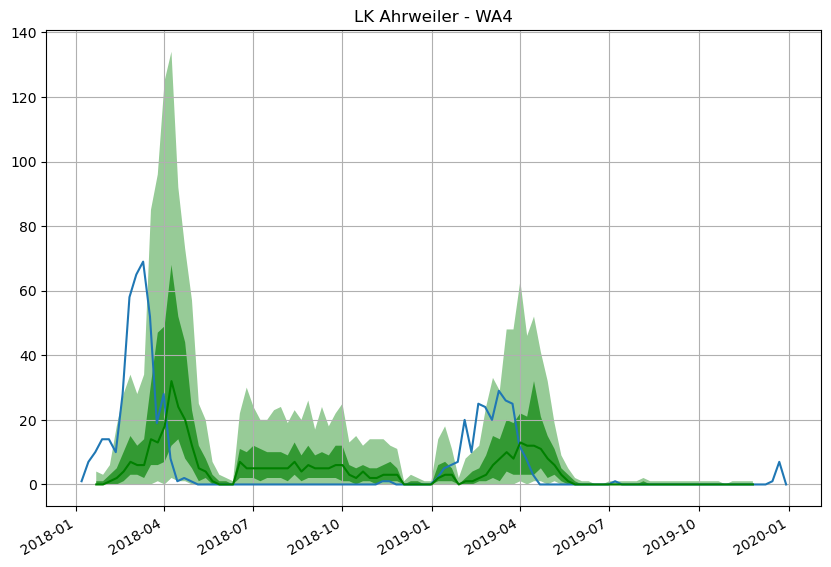

            item_id  Coverage[0.1]  Coverage[0.25]  Coverage[0.5]  \
0  LK Ahrweiler {1}       0.041237        0.268041       0.402062   
0  LK Ahrweiler {2}       0.030928        0.268041       0.381443   
0  LK Ahrweiler {3}       0.010309        0.268041       0.381443   
0  LK Ahrweiler {4}       0.134021        0.329897       0.412371   

   Coverage[0.75]  Coverage[0.9]  
0        0.515464       0.680412  
0        0.484536       0.670103  
0        0.494845       0.670103  
0        0.525773       0.639175  


In [24]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for key in list(forecasts_dict.keys()):
        print(key)
        print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)
        print(evaluator_df_dict[key].loc[evaluator_df.item_id.isin([f"{location}"+" {"+f"{i}" + "}" for location in locations[:1] for i in range(1,5)]),['item_id']+coverage_cols])

In [29]:
print(evaluator_df_dict["DeepAR"].loc[evaluator_df_dict["DeepAR"]["wQuantileLoss[0.75]"]>0])

          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT   660.931000   240030.0        528449.0   
0  aggregated {2}            NaT  1146.276311   316657.0        528449.0   
0  aggregated {3}            NaT  1509.391701   376023.0        528449.0   
0  aggregated {4}            NaT  1696.997280   412233.0        528449.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  ...  \
0        13.255299        1.394398  4.322622  0.633231  0.891652  ...   
0        13.255299        1.394398  5.595305  0.723718  1.039458  ...   
0        13.255299        1.394398  6.614215  0.803344  1.176204  ...   
0        13.255299        1.394398  7.269247  0.865063  1.283687  ...   

   wQuantileLoss[0.1]  wQuantileLoss[0.25]  wQuantileLoss[0.5]  \
0            0.143736             0.302133            0.454216   
0            0.164863             0.366781            0.599220   
0            0.180129             0.414658            0

In [12]:
print([f"{location}"+f" {i}" for location in locations[:3] for i in range(1,5)])

['LK Ahrweiler 1', 'LK Ahrweiler 2', 'LK Ahrweiler 3', 'LK Ahrweiler 4', 'LK Aichach-Friedberg 1', 'LK Aichach-Friedberg 2', 'LK Aichach-Friedberg 3', 'LK Aichach-Friedberg 4', 'LK Alb-Donau-Kreis 1', 'LK Alb-Donau-Kreis 2', 'LK Alb-Donau-Kreis 3', 'LK Alb-Donau-Kreis 4']


In [12]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for location in locations[:5]:
    print(location)
    print(evaluator_df_dict["DeepAR"].loc[evaluator_df.item_id.isin([f"{location}"+" {1}", f"{location}"+" {2}", f"{location}"+" {3}", f"{location}"+" {4}"]),['item_id']+coverage_cols])

LK Ahrweiler
            item_id  Coverage[0.1]  Coverage[0.25]  Coverage[0.5]  \
0  LK Ahrweiler {1}            0.0        0.020619       0.113402   
0  LK Ahrweiler {2}            0.0        0.010309       0.072165   
0  LK Ahrweiler {3}            0.0        0.000000       0.041237   
0  LK Ahrweiler {4}            0.0        0.010309       0.041237   

   Coverage[0.75]  Coverage[0.9]  
0        0.309278       0.463918  
0        0.247423       0.432990  
0        0.185567       0.422680  
0        0.164948       0.391753  
LK Aichach-Friedberg
                    item_id  Coverage[0.1]  Coverage[0.25]  Coverage[0.5]  \
1  LK Aichach-Friedberg {1}       0.010309        0.020619       0.092784   
1  LK Aichach-Friedberg {2}       0.000000        0.010309       0.082474   
1  LK Aichach-Friedberg {3}       0.000000        0.010309       0.061856   
1  LK Aichach-Friedberg {4}       0.000000        0.020619       0.061856   

   Coverage[0.75]  Coverage[0.9]  
1        0.257732       